In [1]:
# Display settings
## Auto reload modules & inline plots
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dt #For inputing any date or time information
from datetime import timezone #For inputing timezones
from google.cloud import bigquery          #The BigQuery API
import matplotlib.pyplot as plt      #For plotting
import numpy as np                         #For scientific computation
import os                            #For work with native operating system and directories
from pathlib import Path             #For working with file paths and directories
import pydata_google_auth                  #For authentication against Google 
import pandas as pd                        #For data manipulation and bgq --> pandas conversion
import pandas_gbq as pd_gbq #Import BigQuery data to create a pandas dataframe
import plotly.graph_objects as go # interactive plots
import pytz #For timezone calculations
import seaborn as sns                #For plotting
import warnings
import datetime

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')

In [4]:
query = """
SELECT
  CUSTOMER_NUMBER,
  ENTERPRISE_ACCOUNT_NO,
  ENTERPRISE_ACCOUNT_NAME,
  NATIONAL_ACCOUNT,
  PAYER,
  DOCUMENT_DATE_IN_DOCUMENT,
  DOCUMENT_TYPE,
  POSTING_KEY_NAME,
  AMOUNT_IN_LOCAL_CURRENCY,
  CREDIT_CONTROL_AREA,
  AR_STATUS,
  PAYMENT_DATE,
  CC_DAYS_TO_ADD
  
FROM
  `edna-data-pr-cah.VW_CORP_GFSS_NP.VW_AR_AGING`
WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))
    AND ("2024-01-01" >=PAYMENT_DATE)
ORDER BY
  PAYMENT_DATE
"""

<font color='red'>check on: WHERE
  (DOCUMENT_TYPE IN ('ZF',
      'VF', 'DH', 'DL', 'DZ', 'DW', 'DC'))</font> 

In [5]:
# Import the data with imputation
bqclient = bigquery.Client()
df = bqclient.query(query).to_dataframe()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49611105 entries, 0 to 49611104
Data columns (total 13 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   CUSTOMER_NUMBER            object
 1   ENTERPRISE_ACCOUNT_NO      object
 2   ENTERPRISE_ACCOUNT_NAME    object
 3   NATIONAL_ACCOUNT           object
 4   PAYER                      object
 5   DOCUMENT_DATE_IN_DOCUMENT  dbdate
 6   DOCUMENT_TYPE              object
 7   POSTING_KEY_NAME           object
 8   AMOUNT_IN_LOCAL_CURRENCY   object
 9   CREDIT_CONTROL_AREA        object
 10  AR_STATUS                  object
 11  PAYMENT_DATE               dbdate
 12  CC_DAYS_TO_ADD             object
dtypes: dbdate(2), object(11)
memory usage: 4.8+ GB


In [7]:
# df['PAYMENT_DATE']=pd.to_datetime(df['PAYMENT_DATE'])
# df.query('"2024-01-01" >=PAYMENT_DATE')

In [8]:
df=df.query('POSTING_KEY_NAME == "01 - Invoice" & AR_STATUS == "CLEAR"')
df['CC_DAYS_TO_ADD']=df['CC_DAYS_TO_ADD'].apply(lambda x: float(x))
df['AMOUNT_IN_LOCAL_CURRENCY']=df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
df.reset_index(inplace = True)


In [9]:
def calc_WAPD(df_1):
    df_1['PAYMENT_DATE']=pd.to_datetime(df_1['PAYMENT_DATE'])
    WAPD_new = pd.Series([])
    for index, row in df_1.iterrows():
        start_date= row['PAYMENT_DATE']
        end_date = row['90_days_ago']
        try:
            ninety_day_range = df_1.query('@start_date >= PAYMENT_DATE >= @end_date')
            WAPD= ninety_day_range['Weighted Invoice Value'].sum() / ninety_day_range['AMOUNT_IN_LOCAL_CURRENCY'].sum()
            WAPD_new[index]=WAPD
        except:
            print('no PAYMENT_DATE')
    df_1.insert(16, "WAPD", WAPD_new)
    return df_1

In [10]:
def search_customer(CUSTOMER_NUMBER):
    CUSTOMER_df=df.query('CUSTOMER_NUMBER == @CUSTOMER_NUMBER')
    CUSTOMER_df.reset_index(inplace = True)
    
    
    CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(CUSTOMER_df['PAYMENT_DATE'])
    CUSTOMER_df['90_days_ago']= current - pd.to_timedelta('90 days')
    CUSTOMER_df = calc_WAPD(CUSTOMER_df)
    return CUSTOMER_df

In [11]:
def search_EAN(CUSTOMER_df):
    # CUSTOMER_df=EN_df.query('ENTERPRISE_ACCOUNT_NO == @ENTERPRISE_ACCOUNT_NO')
    # CUSTOMER_df.reset_index(inplace = True)
   
    # CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']=CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    
    CUSTOMER_df['Sub Payment Date from Invoice Date']=(CUSTOMER_df['PAYMENT_DATE']-CUSTOMER_df['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    CUSTOMER_df['Weighted Invoice Value']= CUSTOMER_df['Sub Payment Date from Invoice Date']*CUSTOMER_df['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(CUSTOMER_df['PAYMENT_DATE'])
    CUSTOMER_df['90_days_ago']= current - pd.to_timedelta('90 days')
    CUSTOMER_df = calc_WAPD(CUSTOMER_df)
    
    
    
    return CUSTOMER_df

In [12]:
def search_EAN_terms(ENTERPRISE_ACCOUNT_NO):
    CUSTOMER_df=df.query('ENTERPRISE_ACCOUNT_NO == @ENTERPRISE_ACCOUNT_NO')
    CUSTOMER_df.reset_index(inplace = True)
    
#     loop for terms 

    four = CUSTOMER_df.query('CC_DAYS_TO_ADD ==4.000000000')
    thirty =CUSTOMER_df.query('CC_DAYS_TO_ADD ==30.000000000')
    sixty =CUSTOMER_df.query('CC_DAYS_TO_ADD ==60.000000000')
    ninty = CUSTOMER_df.query('CC_DAYS_TO_ADD ==90.000000000')

# FOUR



    four['AMOUNT_IN_LOCAL_CURRENCY']=four['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    four['Sub Payment Date from Invoice Date']=(four['PAYMENT_DATE']-four['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    four['Weighted Invoice Value']= four['Sub Payment Date from Invoice Date']*four['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(four['PAYMENT_DATE'])
    four['90_days_ago']= current - pd.to_timedelta('90 days')
    four = calc_WAPD(four)
    
#   THIRTY  
    
    thirty['AMOUNT_IN_LOCAL_CURRENCY']=thirty['AMOUNT_IN_LOCAL_CURRENCY'].apply(lambda x: float(x))
#     Sub Payment Date from Invoice Date
    thirty['Sub Payment Date from Invoice Date']=(thirty['PAYMENT_DATE']-thirty['DOCUMENT_DATE_IN_DOCUMENT']).dt.days
#     Weighted Invoice Value
    thirty['Weighted Invoice Value']= thirty['Sub Payment Date from Invoice Date']*thirty['AMOUNT_IN_LOCAL_CURRENCY']
# WAPD
    import datetime
    current = pd.to_datetime(thirty['PAYMENT_DATE'])
    thirty['90_days_ago']= current - pd.to_timedelta('90 days')
    thirty = calc_WAPD(thirty)
    
    
    
    
    return CUSTOMER_df

# **********************************************************************************************************

# Visualization

## Customer

In [13]:
customer = "2057194397"
t = search_customer(customer)

In [14]:
t.dtypes

level_0                                        int64
index                                          int64
CUSTOMER_NUMBER                               object
ENTERPRISE_ACCOUNT_NO                         object
ENTERPRISE_ACCOUNT_NAME                       object
NATIONAL_ACCOUNT                              object
PAYER                                         object
DOCUMENT_DATE_IN_DOCUMENT                     dbdate
DOCUMENT_TYPE                                 object
POSTING_KEY_NAME                              object
AMOUNT_IN_LOCAL_CURRENCY                     float64
CREDIT_CONTROL_AREA                           object
AR_STATUS                                     object
PAYMENT_DATE                          datetime64[ns]
CC_DAYS_TO_ADD                               float64
Sub Payment Date from Invoice Date             int64
WAPD                                         float64
Weighted Invoice Value                       float64
90_days_ago                           datetime

In [15]:
t['month'] = t['PAYMENT_DATE'].dt.strftime('%b')

In [16]:
year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp1 = pd.pivot_table(data=t, index=[t.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp1 = dfp1.reindex(year_order, axis=1)

In [17]:
dfp1

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PAYMENT_DATE,,,,,,,,,,,,
2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.2435,29.8647,29.9069,29.9826
2023,30.0828,29.5841,27.5906,24.8068,24.9288,24.9342,26.1582,25.3285,26.6899,NaN,NaN,NaN


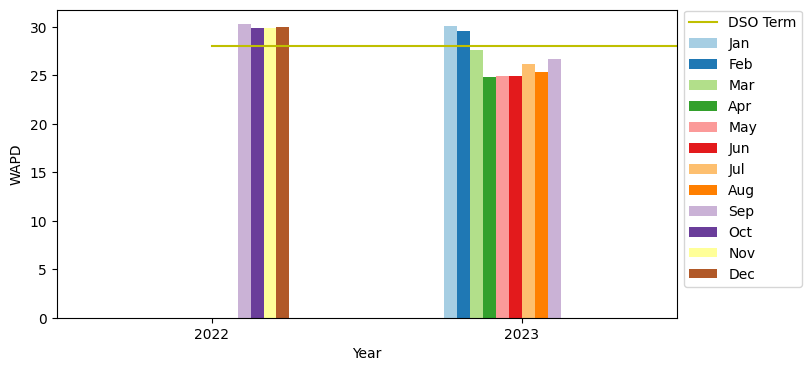

In [18]:
ax = dfp1.plot(kind='bar', figsize=(8, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax.plot(t.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [19]:
# year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
# dfp = pd.pivot_table(data=CONVERSIO_HEALTH_df, index=[CONVERSIO_HEALTH_df.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
# dfp = dfp.reindex(year_order, axis=1)
# dfp

In [20]:
# ax = dfp.plot(kind='bar', figsize=(12, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
# _ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

## EAN

In [21]:
EAN = "7100000391"
s = search_EAN(EAN)

TypeError: string indices must be integers

In [ ]:
four

In [ ]:
four['month'] = four['PAYMENT_DATE'].dt.strftime('%b')
thirty['month'] = thirty['PAYMENT_DATE'].dt.strftime('%b')

In [ ]:
# four = s.query('CC_DAYS_TO_ADD ==4.000000000')
# thirty =s.query('CC_DAYS_TO_ADD ==30.000000000')
# sixty =s.query('CC_DAYS_TO_ADD ==60.000000000')
# ninty = s.query('CC_DAYS_TO_ADD ==90.000000000')

In [ ]:
year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp = pd.pivot_table(data=four, index=[four.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp = dfp.reindex(year_order, axis=1)
dfp

In [ ]:
four.CC_DAYS_TO_ADD.unique()

In [ ]:
s.query('CC_DAYS_TO_ADD ==90.000000000 or CC_DAYS_TO_ADD ==30.000000000 or CC_DAYS_TO_ADD ==60.000000000')

In [ ]:
ax = dfp.plot(kind='bar', figsize=(17, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax.plot(four.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [ ]:
year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp_thirty = pd.pivot_table(data=thirty, index=[thirty.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp_thirty = dfp_thirty.reindex(year_order, axis=1)
dfp_thirty

In [ ]:
thirty

In [ ]:
thirty.CC_DAYS_TO_ADD.unique()

In [ ]:
ax = dfp_thirty.plot(kind='bar', figsize=(10, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax.plot(thirty.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

In [ ]:
s['month'] = s['PAYMENT_DATE'].dt.strftime('%b')

In [ ]:
year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp = pd.pivot_table(data=s, index=[s.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp = dfp.reindex(year_order, axis=1)
dfp

In [ ]:
s.head(2)

In [ ]:
welp = dfp.values[1]

In [ ]:
g = sns.FacetGrid(s, col="CC_DAYS_TO_ADD", col_wrap=2, aspect=2)
g.map_dataframe(sns.barplot, x=dfp.columns, y=welp , color="blue")
# g.map_dataframe(sns.lineplot, x=s.PAYMENT_DATE.dt.year, y="EXPECTED_CASH_FLOW", color="red",alpha=0.5)
g.set_xticklabels(rotation=30)


In [ ]:
df.head()

In [22]:
# Returns a tuple of DataFrames sorted by DSO term

def get_terms(ENTERPRISE_ACCOUNT_NO):
    return_list = []
    
    terms_df=df.query('ENTERPRISE_ACCOUNT_NO == @ENTERPRISE_ACCOUNT_NO')
    
    # terms_df.reset_index(inplace = True)
    terms_list = terms_df['CC_DAYS_TO_ADD'].unique()
    print(terms_list)
    
    for dso_term in terms_list:
        name = str(dso_term)+"_term"
        name = terms_df.query('CC_DAYS_TO_ADD ==@dso_term')
        return_list.append(name)
    
    return return_list
 
# EAN = "7100000391"
# s = get_terms(EAN)

In [ ]:
# terms_list=[]
# for i in s['CC_DAYS_TO_ADD'].unique():
#     print(i)
#     terms_list.append(i)
# ll=s['CC_DAYS_TO_ADD'].unique()


# trying again for terms

In [23]:
EAN = "7100000391"
s = get_terms(EAN)


[ 4. 30. 90. 60.]


In [24]:
s[0].dtypes

index                          int64
CUSTOMER_NUMBER               object
ENTERPRISE_ACCOUNT_NO         object
ENTERPRISE_ACCOUNT_NAME       object
NATIONAL_ACCOUNT              object
PAYER                         object
DOCUMENT_DATE_IN_DOCUMENT     dbdate
DOCUMENT_TYPE                 object
POSTING_KEY_NAME              object
AMOUNT_IN_LOCAL_CURRENCY     float64
CREDIT_CONTROL_AREA           object
AR_STATUS                     object
PAYMENT_DATE                  dbdate
CC_DAYS_TO_ADD               float64
dtype: object

In [26]:
four=search_EAN(s[0])
thirty=search_EAN(s[1])
sixty=search_EAN(s[2])
ninty=search_EAN(s[3])

# for term in s:
#     # print(term.type())
#     search_EAN(s)


In [28]:
ninty

,index,CUSTOMER_NUMBER,ENTERPRISE_ACCOUNT_NO,ENTERPRISE_ACCOUNT_NAME,NATIONAL_ACCOUNT,PAYER,DOCUMENT_DATE_IN_DOCUMENT,DOCUMENT_TYPE,POSTING_KEY_NAME,AMOUNT_IN_LOCAL_CURRENCY,CREDIT_CONTROL_AREA,AR_STATUS,PAYMENT_DATE,CC_DAYS_TO_ADD,Sub Payment Date from Invoice Date,Weighted Invoice Value,WAPD,90_days_ago
8401587,11246866,2057180591,7100000391,7100000391 - STEWARD HEALTH CARE SYSTEM,0000025769,2057180591,2022-09-27,ZF,01 - Invoice,15691.5900,SPD,CLEAR,2022-11-08,60.0000,42,659046.7800,42.0000,2022-08-10


In [29]:
four['month'] = four['PAYMENT_DATE'].dt.strftime('%b')
thirty['month'] = thirty['PAYMENT_DATE'].dt.strftime('%b')
sixty['month'] = sixty['PAYMENT_DATE'].dt.strftime('%b')
ninty['month'] = ninty['PAYMENT_DATE'].dt.strftime('%b')

In [30]:
year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp_4 = pd.pivot_table(data=four, index=[four.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp_4 = dfp_4.reindex(year_order, axis=1)
dfp_4

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PAYMENT_DATE,,,,,,,,,,,,
2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.6671,5.9355,6.1530,6.4311,9.1430
2023,10.8311,10.5710,6.0590,4.7303,6.6613,16.3634,21.5822,25.9741,30.4537,NaN,NaN,NaN


In [31]:
# year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp_30 = pd.pivot_table(data=thirty, index=[thirty.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp_30 = dfp_30.reindex(year_order, axis=1)
dfp_30

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PAYMENT_DATE,,,,,,,,,,,,
2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.7802,51.5348,47.1176,49.0126
2023,50.7768,59.1402,60.8968,56.1709,54.9780,43.9196,45.3093,43.5584,41.7740,NaN,NaN,NaN


In [32]:
# year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp_60 = pd.pivot_table(data=sixty, index=[sixty.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp_60 = dfp_60.reindex(year_order, axis=1)
dfp_60

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PAYMENT_DATE,,,,,,,,,,,,
2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0000,NaN,NaN


In [33]:
# year_order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfp_90 = pd.pivot_table(data=ninty, index=[ninty.PAYMENT_DATE.dt.year], columns='month', values='WAPD')
dfp_90 = dfp_90.reindex(year_order, axis=1)
dfp_90

month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PAYMENT_DATE,,,,,,,,,,,,
2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0000,NaN


In [61]:
ax4 = dfp_4.plot(kind='bar', figsize=(8, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax4.plot(four.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax4.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

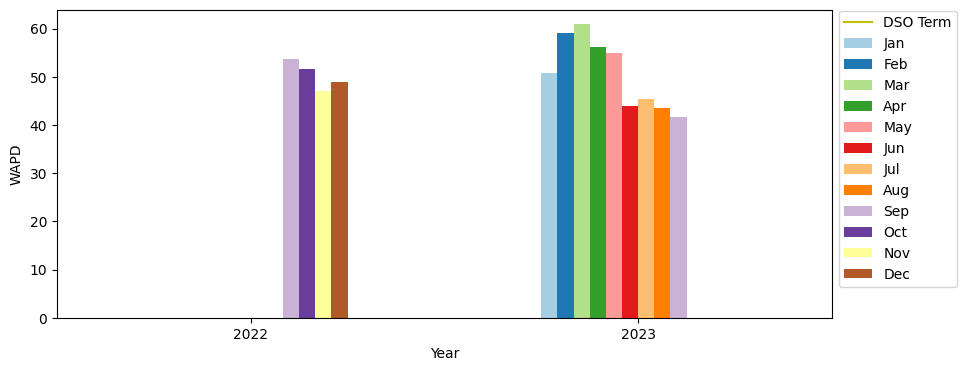

In [40]:
ax30 = dfp_30.plot(kind='bar', figsize=(10, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax30.plot(thirty.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax30.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

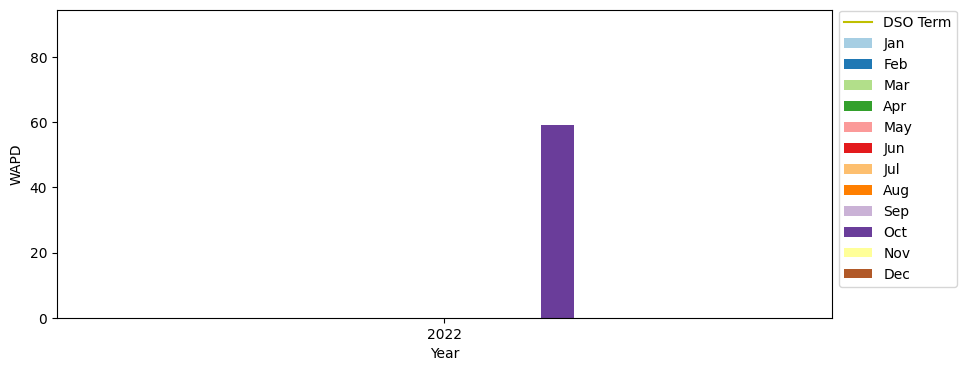

In [41]:
ax60 = dfp_60.plot(kind='bar', figsize=(10, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax60.plot(sixty.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax60.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

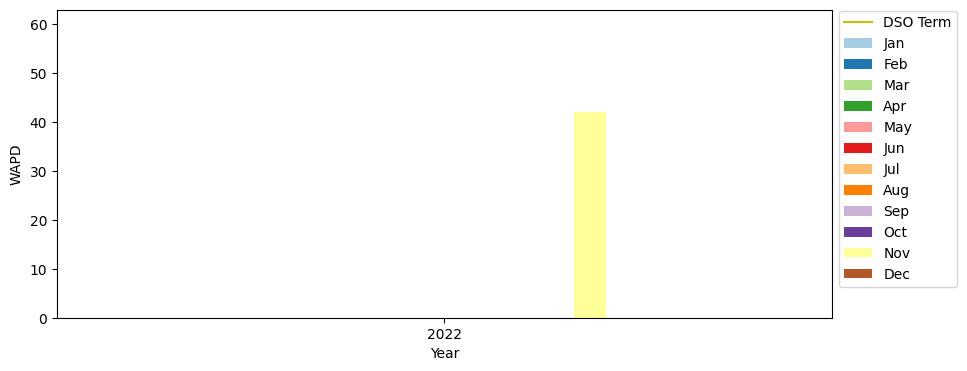

In [42]:
ax90 = dfp_90.plot(kind='bar', figsize=(10, 4), ylabel='WAPD', xlabel='Year', rot=0,colormap='Paired')
ax90.plot(ninty.CC_DAYS_TO_ADD, c = "y", label = "DSO Term")
_ = ax90.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

## National Account